In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from fastai.imports import *
from fastai.sgdr import *
from fastai.conv_learner import *
from fastai.dataset import *
from fastai.transforms import *
from fastai.plots import *

## 1. Initial exploration

In [3]:
PATH = '../data/DigitRecognizer/'
os.listdir(PATH)

['test', 'train.csv', 'test.csv', 'train']

In [4]:
df = pd.read_csv(f'{PATH}train.csv')

In [5]:
df.tail()

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
41995,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
41996,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
41997,7,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
41998,6,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
41999,9,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


## 2. Create label csv

In [12]:
i = [i for i in range(1,df.shape[0]+1)]
d = {'ImageId':i,'Label':df.label}
label = pd.DataFrame(d)
label.head()

,ImageId,Label
0,1,1
1,2,0
2,3,1
3,4,4
4,5,0


In [13]:
label.tail()

,ImageId,Label
41995,41996,0
41996,41997,1
41997,41998,7
41998,41999,6
41999,42000,9


In [14]:
label.to_csv(f'{PATH}label.csv',index = False)

## 3. Create images

### 3.1 Create training images

In [16]:
df_X = df.drop('label',axis=1)
df_X.values.shape

(42000, 784)

In [17]:
X = df_X.values.reshape(-1,28,28)
X.shape

(42000, 28, 28)

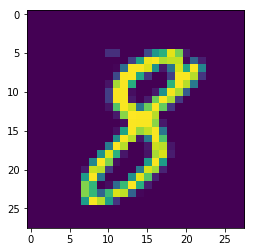

In [18]:
fig = plt.imshow(X[20])

In [19]:
trainPath = PATH+'train/'
for i in tqdm(range(0,X.shape[0])):
    name = trainPath+str(i+1)+'.png'
    plt.imsave(name,X[i])

100%|██████████| 42000/42000 [00:28<00:00, 1467.65it/s]


### 3.2 Creating testing images

In [20]:
test_df = pd.read_csv(PATH+'test.csv')
test_df.shape

(28000, 784)

In [21]:
test_X = test_df.values.reshape(-1,28,28)
test_X.shape

(28000, 28, 28)

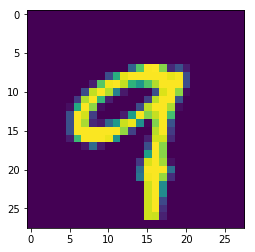

In [22]:
plt.imshow(test_X[20])

In [23]:
testPath = PATH+'test/'
for i in tqdm(range(0,test_X.shape[0])):
    name = testPath+str(i+1)+'.png'
    plt.imsave(name,test_X[i])

100%|██████████| 28000/28000 [00:19<00:00, 1449.57it/s]


## 4. Create training data and learning architectures

In [25]:
val_idxs = get_cv_idxs(X.shape[0])

In [26]:
arch = resnet34
sz = 28
tfms = tfms_from_model(arch,sz)
data = ImageClassifierData.from_csv(PATH,'train', PATH+'label.csv',tfms=tfms,val_idxs= val_idxs,suffix = '.png',test_name='test')
learn = ConvLearner.pretrained(arch,data)

## 5. Training model

In [27]:
learn.lr_find()

HBox(children=(IntProgress(value=0, description='Epoch', max=1), HTML(value='')))

 83%|████████▎ | 438/525 [00:30<00:05, 14.59it/s, loss=2.64] 

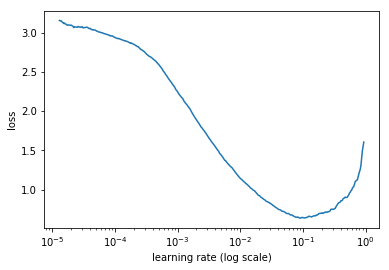

In [29]:
learn.sched.plot()

In [30]:
lr = 1e-2
learn.fit(lr,3,cycle_len = 1)

HBox(children=(IntProgress(value=0, description='Epoch', max=3), HTML(value='')))

  1%|          | 5/525 [00:00<00:53,  9.65it/s, loss=3.04]

Exception in thread Thread-6:
Traceback (most recent call last):
  File "/home/paperspace/anaconda3/envs/fastai/lib/python3.6/threading.py", line 916, in _bootstrap_inner
    self.run()
  File "/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/tqdm/_tqdm.py", line 144, in run
    for instance in self.tqdm_cls._instances:
  File "/home/paperspace/anaconda3/envs/fastai/lib/python3.6/_weakrefset.py", line 60, in __iter__
    for itemref in self.data:
RuntimeError: Set changed size during iteration



epoch      trn_loss   val_loss   accuracy                    
    0      0.378292   0.251982   0.92152   
    1      0.314944   0.203421   0.938447                    
    2      0.279331   0.187217   0.942472                    



[0.18721701, 0.9424715909090909]

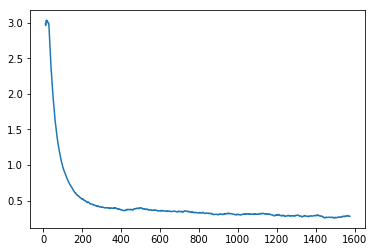

In [31]:
learn.sched.plot_loss()

In [33]:
learn.save('freeze_v1')

In [34]:
learn.unfreeze()
lrs = np.array([lr/100,lr/10,lr])
learn.fit(lrs,3,cycle_len=1,cycle_mult=2)

HBox(children=(IntProgress(value=0, description='Epoch', max=7), HTML(value='')))

epoch      trn_loss   val_loss   accuracy                    
    0      0.163741   0.103543   0.96946   
    1      0.098156   0.062809   0.982008                     
    2      0.05102    0.057542   0.982836                     
    3      0.058813   0.052654   0.984493                     
    4      0.033535   0.047826   0.985204                     
    5      0.020642   0.044154   0.986979                     
    6      0.021739   0.04378    0.987689                     



[0.043780006, 0.9876893939393939]

In [35]:
learn.save('unfreeze_v1')

## 6. Predict and create submisson file

In [38]:
pred_log = learn.predict(True)

In [41]:
pred_log.shape

(28000, 10)

In [49]:
pred_num = [np.argmax(pred_log[i]) for i in range(pred_log.shape[0])]
len(pred_num)

28000

In [54]:
fnames = data.test_ds.fnames;fnames[:3]

['test/27087.png', 'test/21069.png', 'test/20806.png']

In [55]:
imageIds = [imageId[5:-4] for imageId in fnames];imageIds[:3]

['27087', '21069', '20806']

In [56]:
len(imageIds)

28000

In [58]:
sub = pd.DataFrame({'ImageId':imageIds,'Label':pred_num})
sub.tail()

,ImageId,Label
27995,9751,4
27996,9500,6
27997,16858,8
27998,310,5
27999,14413,2


In [59]:
subPath = f'{PATH}sub.csv'
sub.to_csv(subPath,index=False)
FileLink(subPath)

/home/paperspace/practice/data/DigitRecognizer/sub.csv